In [2]:
import rasterio

with rasterio.open('./output/filtered_data.tif') as src:
    print(src.crs)  # 查看坐标系
    print(src.bounds)  # 查看地理边界


EPSG:4326
BoundingBox(left=-66.5, bottom=32.0, right=-65.5, top=33.0)


In [3]:
import xarray as xr

ds = xr.open_dataset('./Data/GCPAF/combined_gcpaf_data.nc')
print(ds)  # 查看坐标信息


<xarray.Dataset> Size: 289kB
Dimensions:    (depth: 1, latitude: 13, longitude: 21, time: 24)
Coordinates:
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 52B -66.5 -66.42 -66.33 ... -65.58 -65.5
  * longitude  (longitude) float32 84B 32.0 32.08 32.08 ... 32.92 32.92 33.0
  * time       (time) datetime64[ns] 192B 2024-11-23 ... 2024-11-23T23:00:00
Data variables:
    so         (time, depth, latitude, longitude) float32 26kB ...
    thetao     (time, depth, latitude, longitude) float32 26kB ...
    uo         (time, depth, latitude, longitude) float32 26kB ...
    vo         (time, depth, latitude, longitude) float32 26kB ...
    zos        (time, depth, latitude, longitude) float32 26kB ...
    utide      (time, depth, latitude, longitude) float32 26kB ...
    utotal     (time, depth, latitude, longitude) float32 26kB ...
    vsdx       (time, depth, latitude, longitude) float32 26kB ...
    vsdy       (time, depth, latitude, longitude) float32 26kB ...
    v

Interpolating variable: so
Interpolating variable: thetao
Interpolating variable: uo
Interpolating variable: vo
Interpolating variable: zos
Interpolating variable: utide
Interpolating variable: utotal
Interpolating variable: vtide
Interpolating variable: vtotal


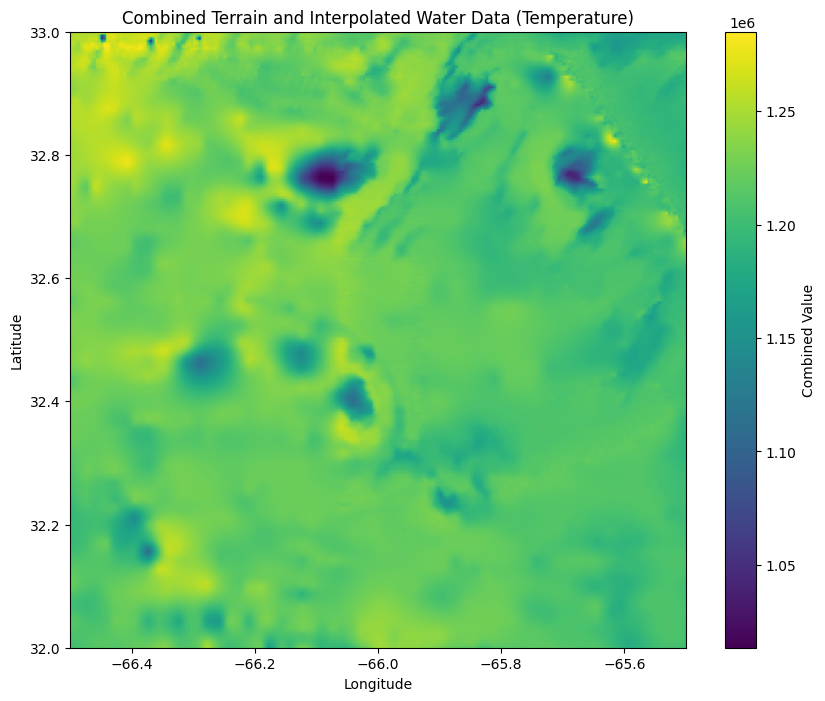

In [6]:
import rasterio
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

# 读取地形文件
with rasterio.open('./output/filtered_data.tif') as src:
    elevation = src.read(1)  # 读取地形数据
    bounds = src.bounds  # 获取地形边界
    transform = src.transform  # 获取仿射变换，用于定位经纬度
    resolution = src.res  # 获取分辨率
    # 计算地形数据的经纬度网格
    lons = np.linspace(bounds.left, bounds.right, src.width)
    lats = np.linspace(bounds.top, bounds.bottom, src.height)

# 读取水体数据
ds = xr.open_dataset('./Data/GCPAF/combined_gcpaf_data.nc')

# 提取原始水体数据的纬度、经度
original_lats = ds['latitude'].values
original_lons = ds['longitude'].values

# 创建网格，用于插值
lon_grid, lat_grid = np.meshgrid(original_lons, original_lats)

# 将地形的纬度和经度展开，生成插值目标网格
target_lon_grid, target_lat_grid = np.meshgrid(lons, lats)

# 对所有水体变量进行插值
variables_to_interpolate = ['so', 'thetao', 'uo', 'vo', 'zos', 'utide', 'utotal', 'vtide', 'vtotal']
interpolated_variables = {}

for var in variables_to_interpolate:
    print(f"Interpolating variable: {var}")
    data = ds[var].isel(time=0, depth=0).values  # 选择特定时间和深度的数据
    rbf_interpolator = Rbf(lon_grid.flatten(), lat_grid.flatten(), data.flatten(), function='linear')
    interpolated_data = rbf_interpolator(target_lon_grid, target_lat_grid)
    interpolated_variables[var] = interpolated_data

# 示例：组合地形数据和插值后的某个水体数据（例如温度）
combined_data = elevation * interpolated_variables['thetao']

# 可视化组合后的数据
plt.figure(figsize=(10, 8))
plt.imshow(combined_data, cmap='viridis', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
plt.colorbar(label='Combined Value')
plt.title('Combined Terrain and Interpolated Water Data (Temperature)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [9]:
import os
import rasterio
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

def interpolate_and_merge(terrain_file, water_file, output_dir):
    # 创建保存插值后数据的目录
    os.makedirs(output_dir, exist_ok=True)

    # 读取地形文件
    with rasterio.open(terrain_file) as src:
        elevation = src.read(1)  # 读取地形数据
        bounds = src.bounds  # 获取地形边界
        transform = src.transform  # 获取仿射变换，用于定位经纬度
        resolution = src.res  # 获取分辨率
        # 计算地形数据的经纬度网格
        lons = np.linspace(bounds.left, bounds.right, src.width)
        lats = np.linspace(bounds.top, bounds.bottom, src.height)

    # 读取水体数据
    ds = xr.open_dataset(water_file)

    # 提取原始水体数据的纬度、经度
    original_lats = ds['latitude'].values
    original_lons = ds['longitude'].values

    # 创建网格，用于插值
    lon_grid, lat_grid = np.meshgrid(original_lons, original_lats)

    # 将地形的纬度和经度展开，生成插值目标网格
    target_lon_grid, target_lat_grid = np.meshgrid(lons, lats)

    # 对所有水体变量进行插值
    variables_to_interpolate = ['so', 'thetao', 'uo', 'vo', 'zos', 'utide', 'utotal', 'vtide', 'vtotal']
    interpolated_variables = {}

    for var in variables_to_interpolate:
        print(f"Interpolating variable: {var}")
        data = ds[var].isel(time=0, depth=0).values  # 选择特定时间和深度的数据

        # 检查并处理 inf 和 NaN
        valid_mask = np.isfinite(data)
        if not valid_mask.any():
            print(f"Warning: All values are NaN or Inf for variable {var}. Skipping.")
            continue

        # 提取有效的数据点进行插值
        valid_lon = lon_grid[valid_mask]
        valid_lat = lat_grid[valid_mask]
        valid_data = data[valid_mask]

        # 使用 RBF 插值，将原始水体数据插值到高分辨率网格上
        rbf_interpolator = Rbf(valid_lon, valid_lat, valid_data, function='linear')
        interpolated_data = rbf_interpolator(target_lon_grid, target_lat_grid)
        interpolated_variables[var] = interpolated_data

        # 保存插值后的数据到 NetCDF 文件
        interpolated_ds = xr.Dataset({var: (['latitude', 'longitude'], interpolated_data)},
                                     coords={'latitude': lats, 'longitude': lons})
        interpolated_ds.to_netcdf(os.path.join(output_dir, f"interpolated_{var}.nc"))

    # 将所有插值后的数据与地形数据合并
    combined_variables = {}
    for var, interpolated_data in interpolated_variables.items():
        combined_variables[var] = (['latitude', 'longitude'], elevation * interpolated_data)

    # 创建包含合并后数据的 Dataset
    combined_ds = xr.Dataset(combined_variables, coords={'latitude': lats, 'longitude': lons})

    # 保存合并后的数据到 NetCDF 文件
    combined_output_path = os.path.join(output_dir, "combined_with_terrain.nc")
    combined_ds.to_netcdf(combined_output_path)

    print(f"All interpolated and combined data have been saved to {output_dir}")

    # 输出合并后数据的一些信息
    print("Combined dataset:")
    print(combined_ds)
    
    print(f"Width (longitude dimension): {src.width}")
    print(f"Height (latitude dimension): {src.height}")


# 调用函数
interpolate_and_merge('./output/filtered_data.tif', './Data/GCPAF/combined_gcpaf_data.nc', './Data/Combined')


Interpolating variable: so
Interpolating variable: thetao
Interpolating variable: uo
Interpolating variable: vo
Interpolating variable: zos
Interpolating variable: utide
Interpolating variable: utotal
Interpolating variable: vtide
Interpolating variable: vtotal
All interpolated and combined data have been saved to ./Data/Combined
Combined dataset:
<xarray.Dataset> Size: 4MB
Dimensions:    (latitude: 240, longitude: 240)
Coordinates:
  * latitude   (latitude) float64 2kB 33.0 33.0 32.99 32.99 ... 32.01 32.0 32.0
  * longitude  (longitude) float64 2kB -66.5 -66.5 -66.49 ... -65.51 -65.5 -65.5
Data variables:
    so         (latitude, longitude) float64 461kB -2.501e+07 ... -2.409e+07
    thetao     (latitude, longitude) float64 461kB 1.247e+06 ... 1.201e+06
    uo         (latitude, longitude) float64 461kB 3.337e+04 ... 3.215e+04
    vo         (latitude, longitude) float64 461kB 2.796e+04 ... 2.693e+04
    zos        (latitude, longitude) float64 461kB 1.324e+06 ... 1.275e+06
    utide

In [11]:
import os
import rasterio
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

def interpolate_and_merge(terrain_file, water_file, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Read terrain file
    with rasterio.open(terrain_file) as src:
        elevation = src.read(1)
        bounds = src.bounds
        lons = np.linspace(bounds.left, bounds.right, src.width)
        lats = np.linspace(bounds.top, bounds.bottom, src.height)

    # Read water data
    ds = xr.open_dataset(water_file)
    original_lats = ds['latitude'].values
    original_lons = ds['longitude'].values

    lon_grid, lat_grid = np.meshgrid(original_lons, original_lats)
    target_lon_grid, target_lat_grid = np.meshgrid(lons, lats)

    variables_to_interpolate = ['so', 'thetao', 'uo', 'vo', 'zos', 'utide', 'utotal', 'vtide', 'vtotal']
    interpolated_variables = {}

    for var in variables_to_interpolate:
        print(f"Interpolating variable: {var}")
        data = ds[var].isel(time=0, depth=0).values

        valid_mask = np.isfinite(data)
        if not valid_mask.any():
            print(f"Warning: All values are NaN or Inf for variable {var}. Skipping.")
            continue

        valid_lon = lon_grid[valid_mask]
        valid_lat = lat_grid[valid_mask]
        valid_data = data[valid_mask]

        rbf_interpolator = Rbf(valid_lon, valid_lat, valid_data, function='linear')
        interpolated_data = rbf_interpolator(target_lon_grid, target_lat_grid)
        interpolated_variables[var] = interpolated_data

        interpolated_ds = xr.Dataset({var: (['latitude', 'longitude'], interpolated_data)},
                                     coords={'latitude': lats, 'longitude': lons})
        interpolated_ds.to_netcdf(os.path.join(output_dir, f"interpolated_{var}.nc"))

    combined_variables = {}
    for var, interpolated_data in interpolated_variables.items():
        combined_variables[var] = (['latitude', 'longitude'], elevation * interpolated_data)

    combined_ds = xr.Dataset(combined_variables, coords={'latitude': lats, 'longitude': lons})
    combined_output_path = os.path.join(output_dir, "combined_with_terrain.nc")
    combined_ds.to_netcdf(combined_output_path)

    print(f"All interpolated and combined data have been saved to {output_dir}")
    print("Combined dataset:")
    print(combined_ds)

# Call the function
interpolate_and_merge('./output/filtered_data.tif', './Data/GCPAF/combined_gcpaf_data.nc', './Data/Combined')


Interpolating variable: so
Interpolating variable: thetao
Interpolating variable: uo
Interpolating variable: vo
Interpolating variable: zos
Interpolating variable: utide
Interpolating variable: utotal
Interpolating variable: vtide
Interpolating variable: vtotal
All interpolated and combined data have been saved to ./Data/Combined
Combined dataset:
<xarray.Dataset> Size: 4MB
Dimensions:    (latitude: 240, longitude: 240)
Coordinates:
  * latitude   (latitude) float64 2kB 33.0 33.0 32.99 32.99 ... 32.01 32.0 32.0
  * longitude  (longitude) float64 2kB -66.5 -66.5 -66.49 ... -65.51 -65.5 -65.5
Data variables:
    so         (latitude, longitude) float64 461kB -2.501e+07 ... -2.409e+07
    thetao     (latitude, longitude) float64 461kB 1.247e+06 ... 1.201e+06
    uo         (latitude, longitude) float64 461kB 3.337e+04 ... 3.215e+04
    vo         (latitude, longitude) float64 461kB 2.796e+04 ... 2.693e+04
    zos        (latitude, longitude) float64 461kB 1.324e+06 ... 1.275e+06
    utide

In [12]:
def print_combined_data_structure(combined_file):
    # Read combined data file
    combined_ds = xr.open_dataset(combined_file)
    # Print the structure of the dataset
    print("Combined dataset structure:")
    print(combined_ds)



# Print the structure of the combined dataset
print_combined_data_structure('./Data/Combined/combined_with_terrain.nc')


Combined dataset structure:
<xarray.Dataset> Size: 4MB
Dimensions:    (latitude: 240, longitude: 240)
Coordinates:
  * latitude   (latitude) float64 2kB 33.0 33.0 32.99 32.99 ... 32.01 32.0 32.0
  * longitude  (longitude) float64 2kB -66.5 -66.5 -66.49 ... -65.51 -65.5 -65.5
Data variables:
    so         (latitude, longitude) float64 461kB ...
    thetao     (latitude, longitude) float64 461kB ...
    uo         (latitude, longitude) float64 461kB ...
    vo         (latitude, longitude) float64 461kB ...
    zos        (latitude, longitude) float64 461kB ...
    utide      (latitude, longitude) float64 461kB ...
    utotal     (latitude, longitude) float64 461kB ...
    vtide      (latitude, longitude) float64 461kB ...
    vtotal     (latitude, longitude) float64 461kB ...


Interpolating variable: so
Interpolating variable: thetao
Interpolating variable: uo
Interpolating variable: vo
Interpolating variable: zos
Interpolating variable: utide
Interpolating variable: utotal
Interpolating variable: vtide
Interpolating variable: vtotal
All interpolated and combined data have been saved to ./Data/Combined
Combined dataset:
<xarray.Dataset> Size: 4MB
Dimensions:    (latitude: 240, longitude: 240)
Coordinates:
  * latitude   (latitude) float64 2kB 33.0 33.0 32.99 32.99 ... 32.01 32.0 32.0
  * longitude  (longitude) float64 2kB -66.5 -66.5 -66.49 ... -65.51 -65.5 -65.5
Data variables:
    so         (latitude, longitude) float64 461kB -2.501e+07 ... -2.409e+07
    thetao     (latitude, longitude) float64 461kB 1.247e+06 ... 1.201e+06
    uo         (latitude, longitude) float64 461kB 3.337e+04 ... 3.215e+04
    vo         (latitude, longitude) float64 461kB 2.796e+04 ... 2.693e+04
    zos        (latitude, longitude) float64 461kB 1.324e+06 ... 1.275e+06
    utide

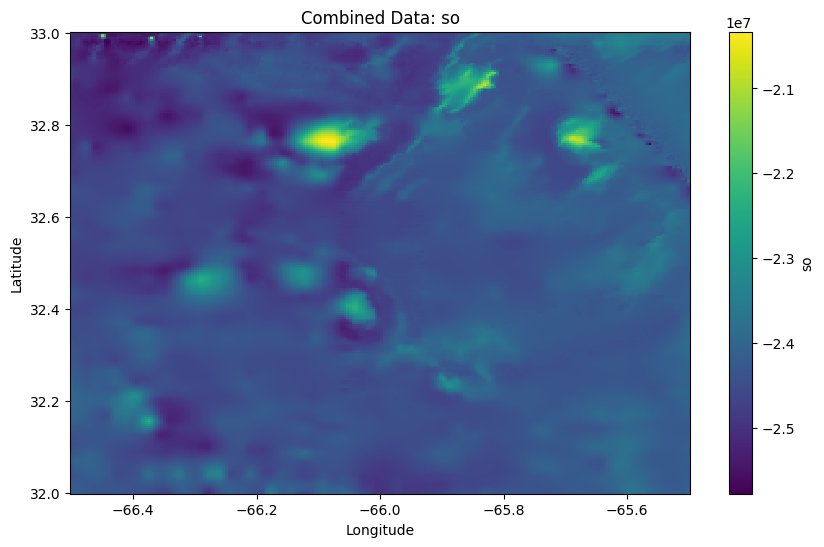

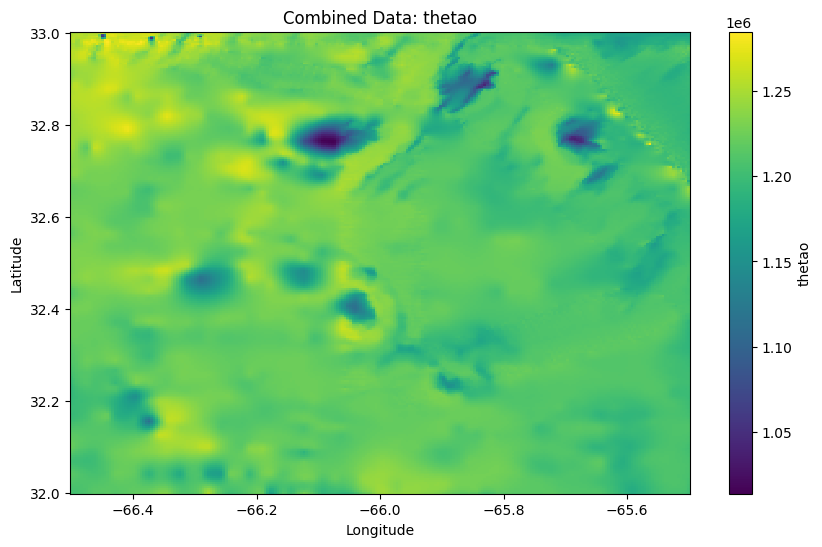

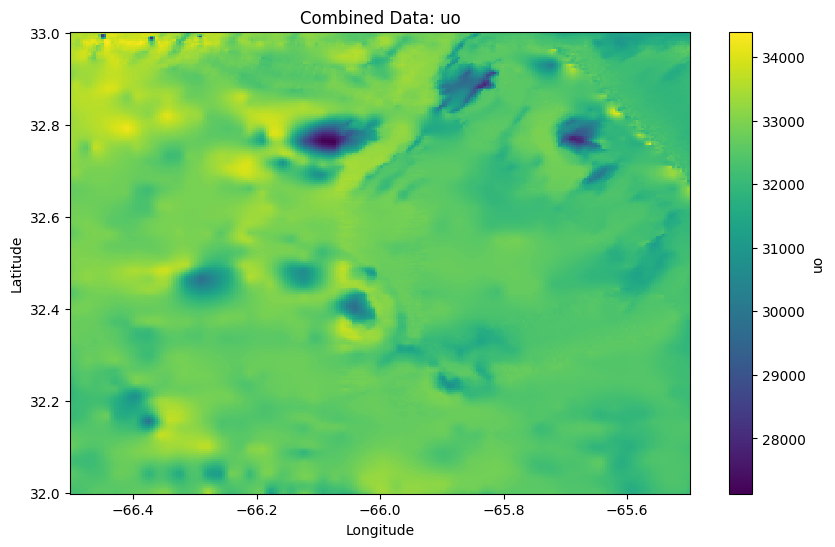

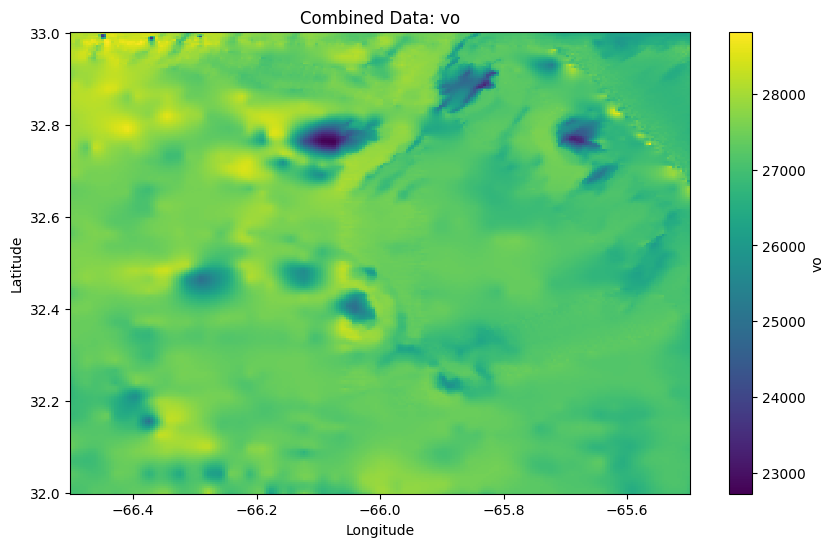

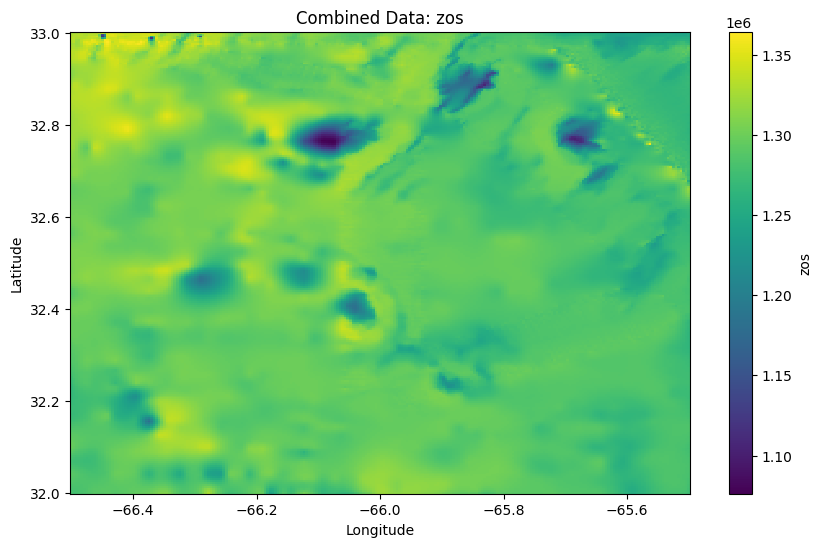

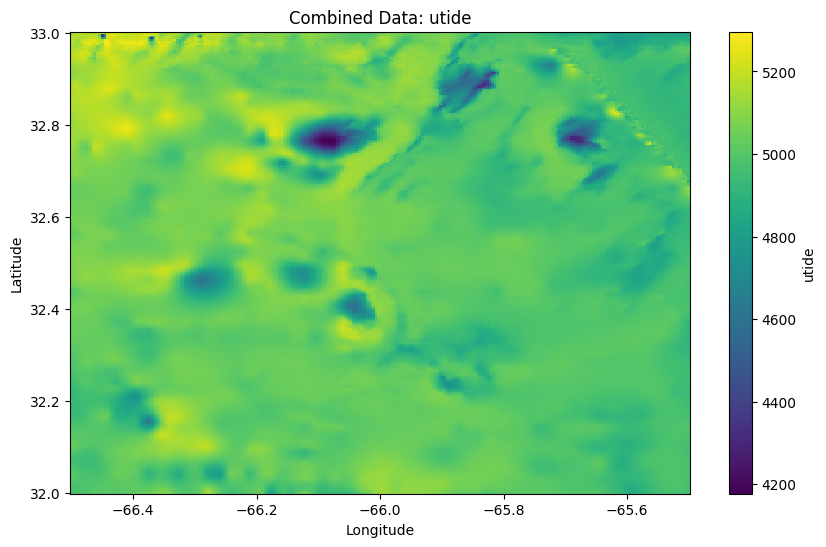

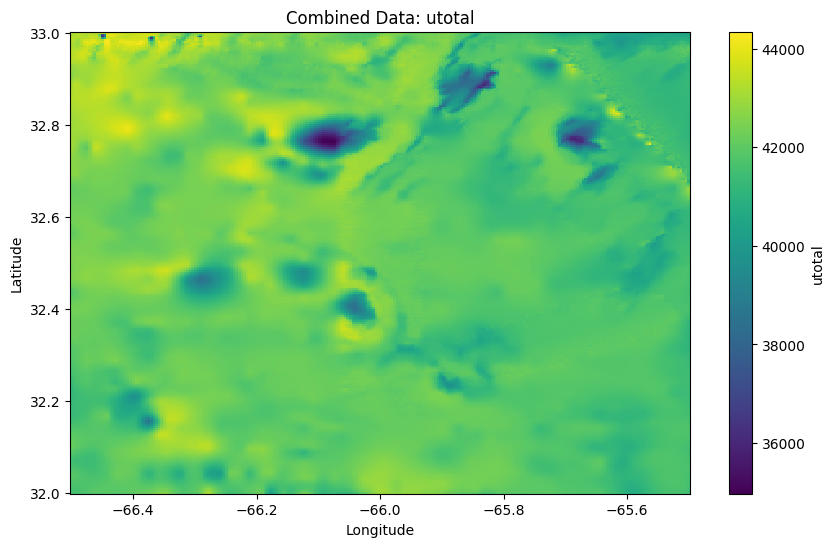

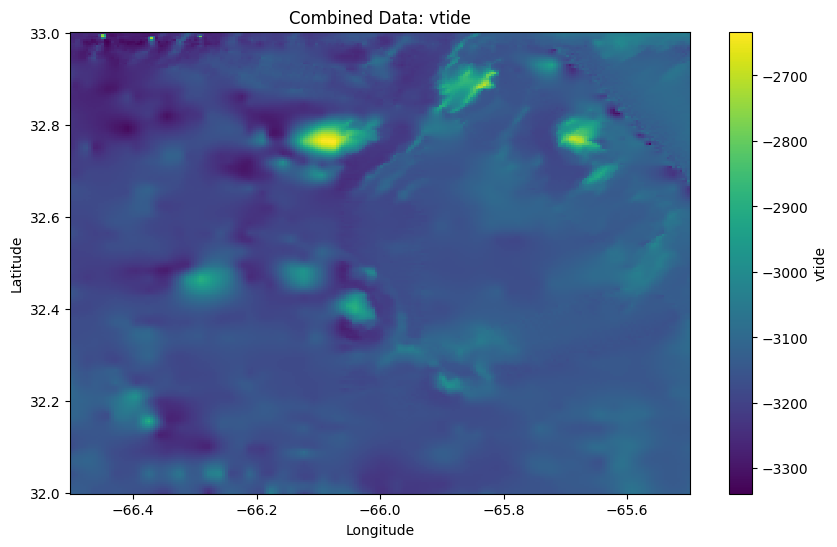

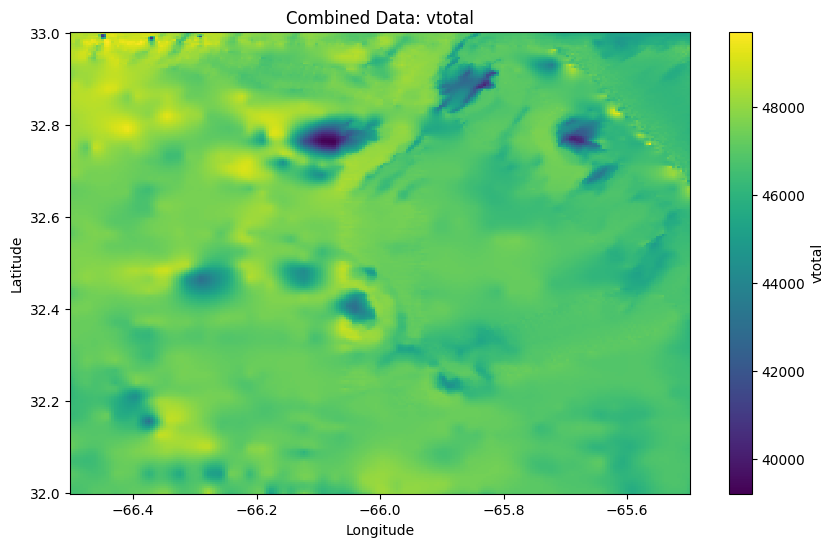

In [13]:
import os
import rasterio
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

def interpolate_and_merge(terrain_file, water_file, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Read terrain file
    with rasterio.open(terrain_file) as src:
        elevation = src.read(1)
        bounds = src.bounds
        lons = np.linspace(bounds.left, bounds.right, src.width)
        lats = np.linspace(bounds.top, bounds.bottom, src.height)

    # Read water data
    ds = xr.open_dataset(water_file)
    original_lats = ds['latitude'].values
    original_lons = ds['longitude'].values

    lon_grid, lat_grid = np.meshgrid(original_lons, original_lats)
    target_lon_grid, target_lat_grid = np.meshgrid(lons, lats)

    variables_to_interpolate = ['so', 'thetao', 'uo', 'vo', 'zos', 'utide', 'utotal', 'vtide', 'vtotal']
    interpolated_variables = {}

    for var in variables_to_interpolate:
        print(f"Interpolating variable: {var}")
        data = ds[var].isel(time=0, depth=0).values

        valid_mask = np.isfinite(data)
        if not valid_mask.any():
            print(f"Warning: All values are NaN or Inf for variable {var}. Skipping.")
            continue

        valid_lon = lon_grid[valid_mask]
        valid_lat = lat_grid[valid_mask]
        valid_data = data[valid_mask]

        rbf_interpolator = Rbf(valid_lon, valid_lat, valid_data, function='linear')
        interpolated_data = rbf_interpolator(target_lon_grid, target_lat_grid)
        interpolated_variables[var] = interpolated_data

        interpolated_ds = xr.Dataset({var: (['latitude', 'longitude'], interpolated_data)},
                                     coords={'latitude': lats, 'longitude': lons})
        interpolated_ds.to_netcdf(os.path.join(output_dir, f"interpolated_{var}.nc"))

    combined_variables = {}
    for var, interpolated_data in interpolated_variables.items():
        combined_variables[var] = (['latitude', 'longitude'], elevation * interpolated_data)

    combined_ds = xr.Dataset(combined_variables, coords={'latitude': lats, 'longitude': lons})
    combined_output_path = os.path.join(output_dir, "combined_with_terrain.nc")
    combined_ds.to_netcdf(combined_output_path)

    print(f"All interpolated and combined data have been saved to {output_dir}")
    print("Combined dataset:")
    print(combined_ds)

def visualize_combined_data(combined_file):
    # Read combined data file
    combined_ds = xr.open_dataset(combined_file)

    # Plot each variable in the combined dataset
    for var in combined_ds.data_vars:
        plt.figure(figsize=(10, 6))
        combined_ds[var].plot()
        plt.title(f"Combined Data: {var}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()

# Call the function
interpolate_and_merge('./output/filtered_data.tif', './Data/GCPAF/combined_gcpaf_data.nc', './Data/Combined')

# Visualize the combined data
visualize_combined_data('./Data/Combined/combined_with_terrain.nc')


Interpolating variable: so
  Time: 2024-11-23T00:00:00.000000000, Depth: 0.49402499198913574
  Time: 2024-11-23T01:00:00.000000000, Depth: 0.49402499198913574
  Time: 2024-11-23T02:00:00.000000000, Depth: 0.49402499198913574
  Time: 2024-11-23T03:00:00.000000000, Depth: 0.49402499198913574
  Time: 2024-11-23T04:00:00.000000000, Depth: 0.49402499198913574
  Time: 2024-11-23T05:00:00.000000000, Depth: 0.49402499198913574
  Time: 2024-11-23T06:00:00.000000000, Depth: 0.49402499198913574
  Time: 2024-11-23T07:00:00.000000000, Depth: 0.49402499198913574
  Time: 2024-11-23T08:00:00.000000000, Depth: 0.49402499198913574
  Time: 2024-11-23T09:00:00.000000000, Depth: 0.49402499198913574
  Time: 2024-11-23T10:00:00.000000000, Depth: 0.49402499198913574
  Time: 2024-11-23T11:00:00.000000000, Depth: 0.49402499198913574
  Time: 2024-11-23T12:00:00.000000000, Depth: 0.49402499198913574
  Time: 2024-11-23T13:00:00.000000000, Depth: 0.49402499198913574
  Time: 2024-11-23T14:00:00.000000000, Depth: 0.4

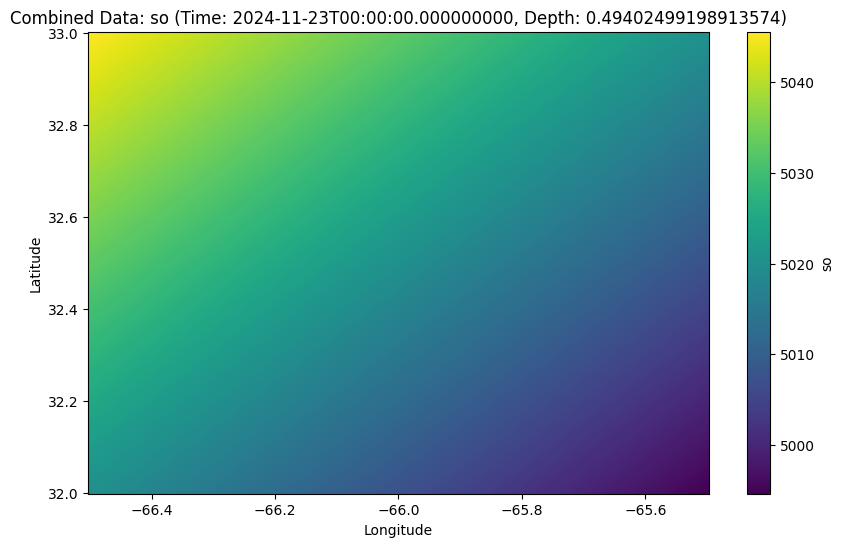

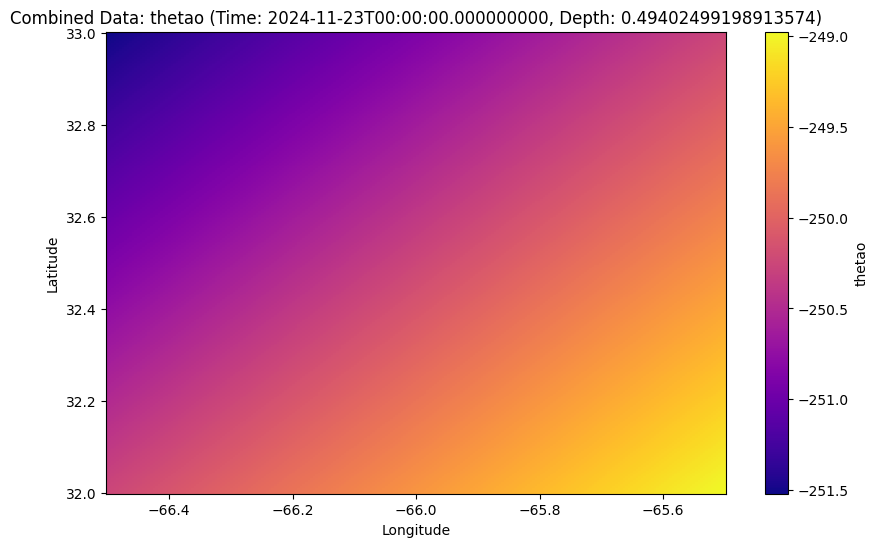

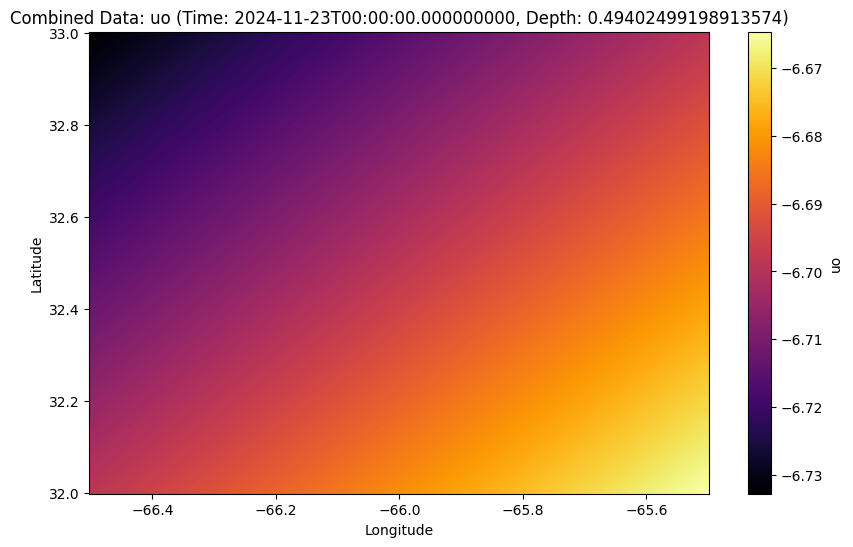

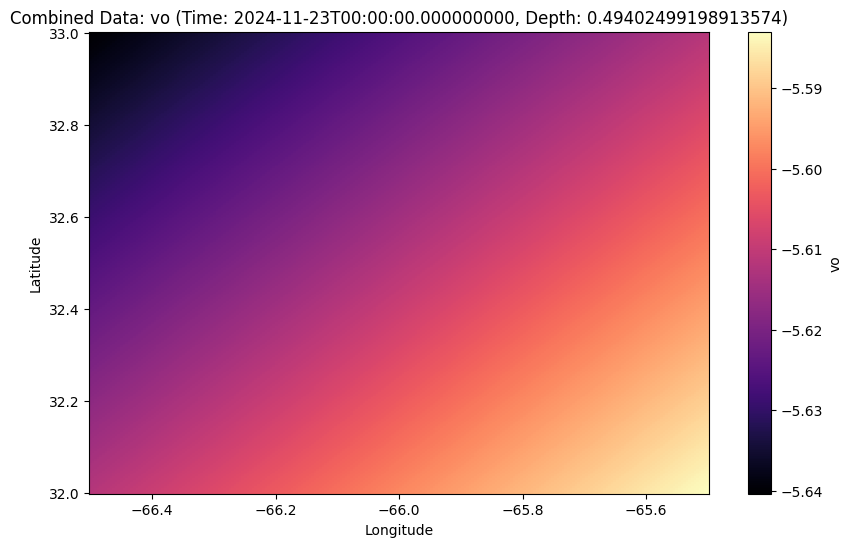

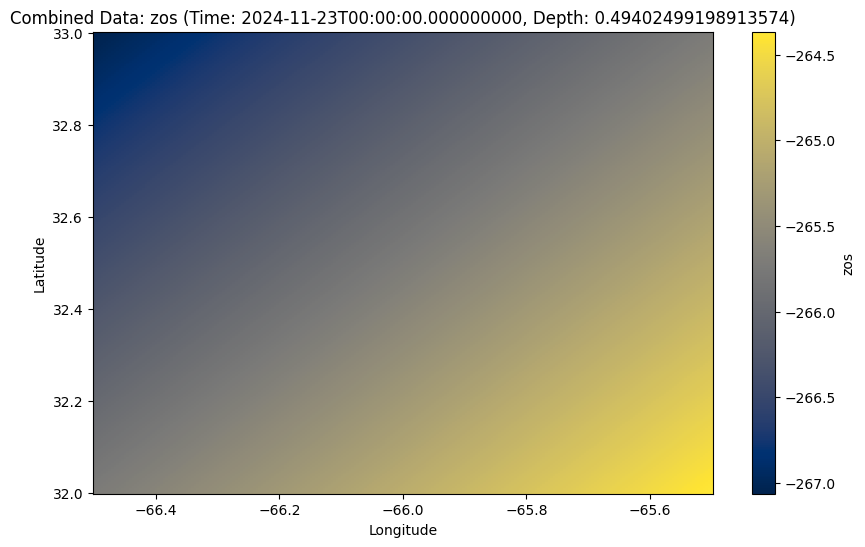

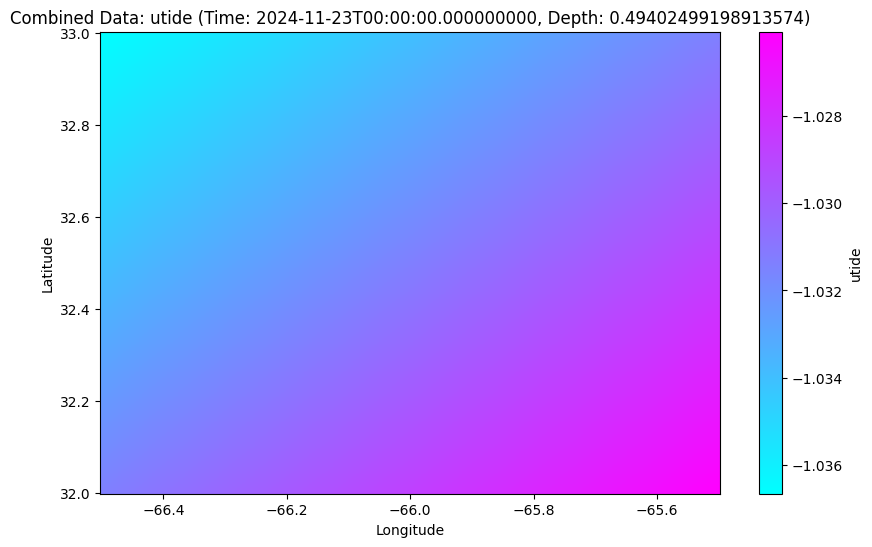

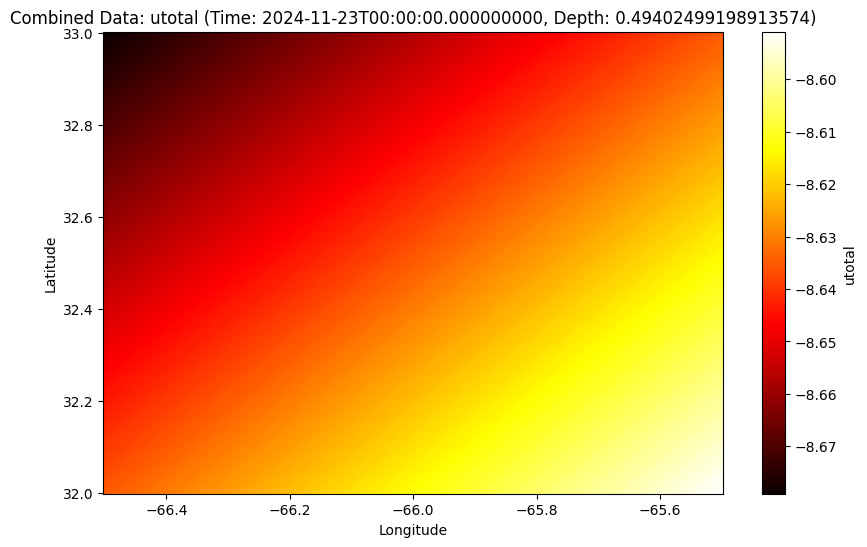

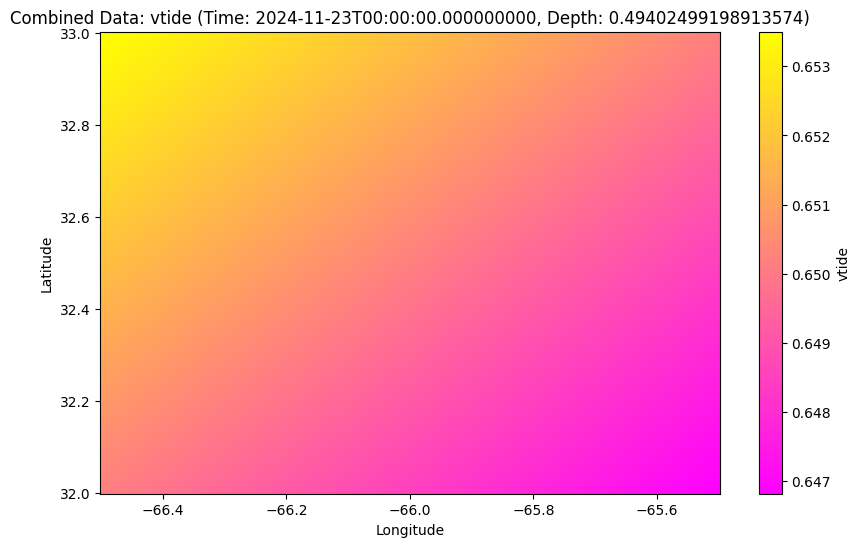

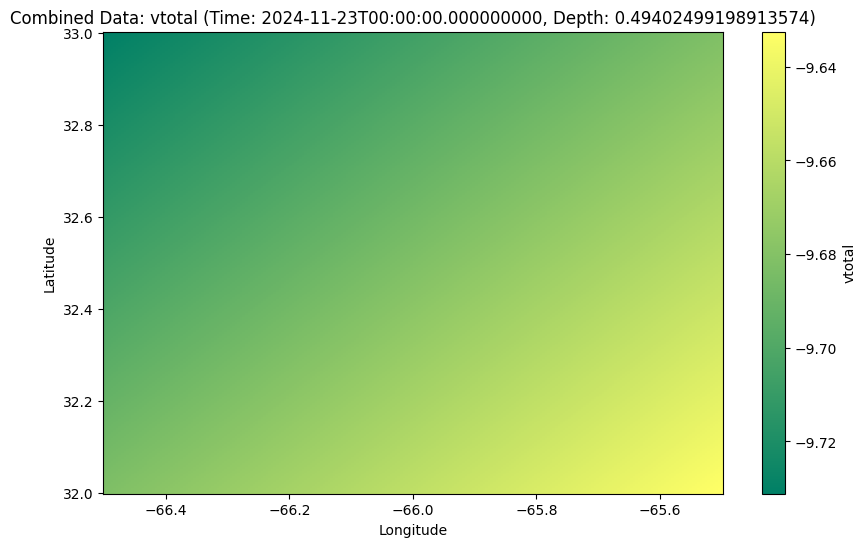

In [16]:
import os
import rasterio
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

def interpolate_and_merge(terrain_file, water_file, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Read terrain file
    with rasterio.open(terrain_file) as src:
        elevation = src.read(1)
        bounds = src.bounds
        lons = np.linspace(bounds.left, bounds.right, src.width)
        lats = np.linspace(bounds.top, bounds.bottom, src.height)

    # Read water data
    ds = xr.open_dataset(water_file)
    original_lats = ds['latitude'].values
    original_lons = ds['longitude'].values
    original_depths = ds['depth'].values
    original_times = ds['time'].values

    lon_grid, lat_grid = np.meshgrid(original_lons, original_lats)
    target_lon_grid, target_lat_grid = np.meshgrid(lons, lats)

    variables_to_interpolate = ['so', 'thetao', 'uo', 'vo', 'zos', 'utide', 'utotal', 'vtide', 'vtotal']
    interpolated_variables = {var: [] for var in variables_to_interpolate}

    for var in variables_to_interpolate:
        print(f"Interpolating variable: {var}")

        for t_idx, time in enumerate(original_times):
            for d_idx, depth in enumerate(original_depths):
                print(f"  Time: {time}, Depth: {depth}")
                data = ds[var].isel(time=t_idx, depth=d_idx).values

                valid_mask = np.isfinite(data)
                if not valid_mask.any():
                    print(f"  Warning: All values are NaN or Inf for variable {var} at time {time}, depth {depth}. Skipping.")
                    interpolated_variables[var].append(np.full((len(lats), len(lons)), np.nan))
                    continue

                valid_lon = lon_grid[valid_mask]
                valid_lat = lat_grid[valid_mask]
                valid_data = data[valid_mask]

                rbf_interpolator = Rbf(valid_lon, valid_lat, valid_data, function='linear')
                interpolated_data = rbf_interpolator(target_lon_grid, target_lat_grid)
                interpolated_variables[var].append(interpolated_data)

    combined_variables = {}
    for var, interpolated_list in interpolated_variables.items():
        # Stack the list of interpolated data along time and depth dimensions
        stacked_data = np.stack(interpolated_list, axis=0)
        stacked_data = stacked_data.reshape((len(original_times), len(original_depths), len(lats), len(lons)))
        combined_variables[var] = (['time', 'depth', 'latitude', 'longitude'], stacked_data)

    combined_ds = xr.Dataset(combined_variables, coords={'time': original_times, 'depth': original_depths, 'latitude': lats, 'longitude': lons})
    combined_output_path = os.path.join(output_dir, "combined_with_terrain.nc")
    combined_ds.to_netcdf(combined_output_path)

    print(f"All interpolated and combined data have been saved to {output_dir}")
    print("Combined dataset:")
    print(combined_ds)

def visualize_combined_data(combined_file, selected_time=None, selected_depth=None, time_index=None, depth_index=None):
    # Read combined data file
    combined_ds = xr.open_dataset(combined_file)

    # Determine selected time and depth
    if time_index is not None:
        selected_time = combined_ds['time'].values[time_index]
    if depth_index is not None:
        selected_depth = combined_ds['depth'].values[depth_index]

    # Output data characteristics for each variable
    for var in combined_ds.data_vars:
        data = combined_ds[var]
        print(f"Data characteristics for variable {var}:")
        print(f"  Mean: {data.mean().item()} ")
        print(f"  Std Dev: {data.std().item()} ")
        print(f"  Min: {data.min().item()} ")
        print(f"  Max: {data.max().item()} ")

    # Plot each variable in the combined dataset with different colormaps
    colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'cool', 'hot', 'spring', 'summer']
    for i, var in enumerate(combined_ds.data_vars):
        if selected_time is not None and selected_depth is not None:
            plt.figure(figsize=(10, 6))
            combined_ds[var].sel(time=selected_time, depth=selected_depth).plot(cmap=colormaps[i % len(colormaps)])
            plt.title(f"Combined Data: {var} (Time: {selected_time}, Depth: {selected_depth})")
            plt.xlabel("Longitude")
            plt.ylabel("Latitude")
            plt.show()
        else:
            for t_idx in range(len(combined_ds['time'])):
                for d_idx in range(len(combined_ds['depth'])):
                    plt.figure(figsize=(10, 6))
                    combined_ds[var].isel(time=t_idx, depth=d_idx).plot(cmap=colormaps[i % len(colormaps)])
                    plt.title(f"Combined Data: {var} (Time: {combined_ds['time'].values[t_idx]}, Depth: {combined_ds['depth'].values[d_idx]})")
                    plt.xlabel("Longitude")
                    plt.ylabel("Latitude")
                    plt.show()

def print_combined_data_structure(combined_file):
    combined_ds = xr.open_dataset(combined_file)
    print("Combined dataset structure:")
    print(combined_ds)

interpolate_and_merge('./output/filtered_data.tif', './Data/GCPAF/combined_gcpaf_data.nc', './Data/Combined')

# visualize
visualize_combined_data('./Data/Combined/combined_with_terrain.nc', time_index=0, depth_index=0)

In [19]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np

def visualize_by_time(data_file, output_dir):
    # Read combined data file
    combined_ds = xr.open_dataset(data_file)

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get time values
    times = combined_ds['time'].values

    # Loop through each variable and visualize its trend over time
    for var in combined_ds.data_vars:
        plt.figure(figsize=(12, 6))
        mean_values = []

        # Calculate the mean value for each time step
        for t_idx in range(len(times)):
            data = combined_ds[var].isel(time=t_idx)
            mean_values.append(data.mean().item())

        # Plot the trend over time
        plt.plot(times, mean_values, marker='o', linestyle='-', label=var)
        plt.title(f"Temporal Trend of {var}")
        plt.xlabel("Time")
        plt.ylabel(f"Mean {var}")
        plt.grid(True)
        plt.legend()

        # Save the figure
        output_path = os.path.join(output_dir, f"{var}_trend_over_time.png")
        plt.savefig(output_path)
        plt.close()

        print(f"Saved temporal trend visualization for variable '{var}' to '{output_path}'")

# Example usage
visualize_by_time('./Data/Combined/combined_with_terrain.nc', './Data/Visualizations')


Saved temporal trend visualization for variable 'so' to './Data/Visualizations/so_trend_over_time.png'
Saved temporal trend visualization for variable 'thetao' to './Data/Visualizations/thetao_trend_over_time.png'
Saved temporal trend visualization for variable 'uo' to './Data/Visualizations/uo_trend_over_time.png'
Saved temporal trend visualization for variable 'vo' to './Data/Visualizations/vo_trend_over_time.png'
Saved temporal trend visualization for variable 'zos' to './Data/Visualizations/zos_trend_over_time.png'
Saved temporal trend visualization for variable 'utide' to './Data/Visualizations/utide_trend_over_time.png'
Saved temporal trend visualization for variable 'utotal' to './Data/Visualizations/utotal_trend_over_time.png'
Saved temporal trend visualization for variable 'vtide' to './Data/Visualizations/vtide_trend_over_time.png'
Saved temporal trend visualization for variable 'vtotal' to './Data/Visualizations/vtotal_trend_over_time.png'


In [20]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np

def visualize_by_time(data_file, output_dir, lat_idx, lon_idx):
    # Read combined data file
    combined_ds = xr.open_dataset(data_file)

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get time values
    times = combined_ds['time'].values

    # Loop through each variable and visualize its trend over time at a specific point
    for var in combined_ds.data_vars:
        plt.figure(figsize=(12, 6))
        point_values = []

        # Extract the value for each time step at the specified latitude and longitude index
        for t_idx in range(len(times)):
            data = combined_ds[var].isel(time=t_idx, latitude=lat_idx, longitude=lon_idx)
            point_values.append(data.item())

        # Plot the trend over time
        plt.plot(times, point_values, marker='o', linestyle='-', label=var)
        plt.title(f"Temporal Trend of {var} at Point (lat_idx={lat_idx}, lon_idx={lon_idx})")
        plt.xlabel("Time")
        plt.ylabel(f"{var} Value at Specified Point")
        plt.grid(True)
        plt.legend()

        # Save the figure
        output_path = os.path.join(output_dir, f"{var}_trend_over_time_at_point.png")
        plt.savefig(output_path)
        plt.close()

        print(f"Saved temporal trend visualization for variable '{var}' at point (lat_idx={lat_idx}, lon_idx={lon_idx}) to '{output_path}'")

# Example usage
visualize_by_time('./Data/Combined/combined_with_terrain.nc', './Data/Visualizations', lat_idx=10, lon_idx=15)


Saved temporal trend visualization for variable 'so' at point (lat_idx=10, lon_idx=15) to './Data/Visualizations/so_trend_over_time_at_point.png'
Saved temporal trend visualization for variable 'thetao' at point (lat_idx=10, lon_idx=15) to './Data/Visualizations/thetao_trend_over_time_at_point.png'
Saved temporal trend visualization for variable 'uo' at point (lat_idx=10, lon_idx=15) to './Data/Visualizations/uo_trend_over_time_at_point.png'
Saved temporal trend visualization for variable 'vo' at point (lat_idx=10, lon_idx=15) to './Data/Visualizations/vo_trend_over_time_at_point.png'
Saved temporal trend visualization for variable 'zos' at point (lat_idx=10, lon_idx=15) to './Data/Visualizations/zos_trend_over_time_at_point.png'
Saved temporal trend visualization for variable 'utide' at point (lat_idx=10, lon_idx=15) to './Data/Visualizations/utide_trend_over_time_at_point.png'
Saved temporal trend visualization for variable 'utotal' at point (lat_idx=10, lon_idx=15) to './Data/Visual